Recent 12hours rate
Datetime
2020-10-19 21:00    105.502
2020-10-20 21:00    104.591
2020-10-21 21:00    104.845
2020-10-22 21:00    104.709
2020-10-25 21:00    104.834
2020-10-26 21:00    104.416
2020-10-27 21:00    104.314
2020-10-28 21:00    104.602
2020-10-29 21:00    104.620
2020-11-01 22:00    104.695
2020-11-02 22:00    104.531
2020-11-03 22:00    105.299
Name: Close, dtype: object

                  Volume_x  SMA/current_x      RSI_x    MACD_x  BBANDS+2σ_x  \
Datetime                                                                      
2020-09-06 21:00   92231.0       1.001275  50.558050 -0.043141     1.013965   
2020-09-07 21:00   94184.0       0.999989  51.073812 -0.005542     1.013433   
2020-09-08 21:00   75715.0       0.998241  53.447188  0.099992     1.011213   
2020-09-09 21:00   82228.0       0.997431  53.589723  0.147073     1.010882   
2020-09-10 21:00   72276.0       0.998643  54.131838  0.178553     1.010540   
2020-09-13 21:00   41251.0       0.999036  54.522380  

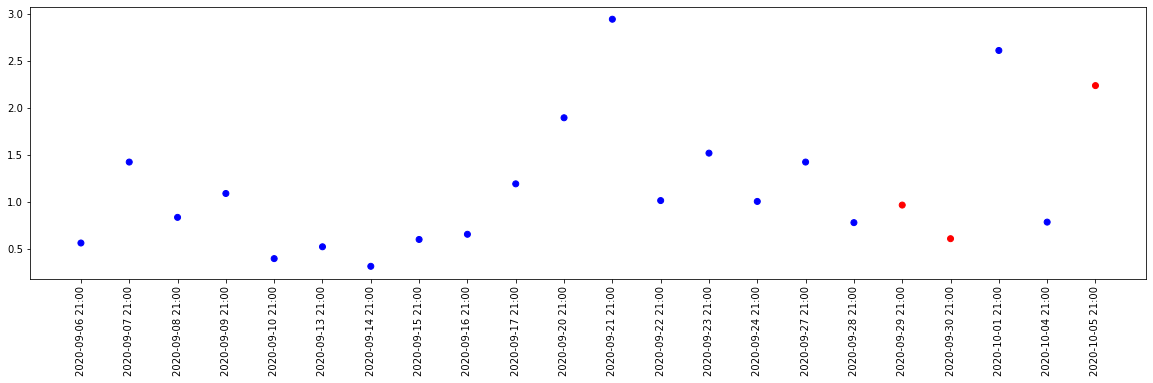

next is DOWN


In [10]:
# -*- coding: utf-8 -*-
from oandapyV20 import API
from oandapyV20.exceptions import V20Error
from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.instruments as instruments

import json
import datetime
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta

import time


#自分のアカウント、トークンをセット
accountID = "101-009-16415310-001"
access_token = '860c2d2dbbcd01b6d95939b6af6b5981-8664724ce0870220c55161d704137df6'

api = API(access_token=access_token, environment="practice")
        
# Oandaからcandleデータを取得する。
def getCandleDataFromOanda(instrument, api, date_from, date_to, granularity):
    params = {
        "from": date_from.isoformat(),
        "to": date_to.isoformat(),
        "granularity": granularity,
    }
    r = instruments.InstrumentsCandles(instrument=instrument, params=params)
    return api.request(r)

def oandaJsonToPythonList(JSONRes):
    
    data = []
    for res in JSONRes['candles']:
        temp = [(datetime.datetime.fromisoformat(res['time'][:19])).strftime('%Y-%m-%d %H:%M')]#indexとなる時間を追加
                
        temp.extend([res['volume'],
            res['mid']['o'],
            res['mid']['h'],
            res['mid']['l'],
            res['mid']['c'],
            ])
        data.append(temp)
    return data




def select_data(period_Days, money='USD_JPY', foot = 'D'):
    all_data = []
    
    NY = datetime.timedelta(hours=-14)
    
    date_from = datetime.datetime.now()+datetime.timedelta(days=-period_Days) + NY
    date_to = datetime.datetime.now() + NY + datetime.timedelta(seconds=-1)

    ret = getCandleDataFromOanda(money, api, date_from, date_to, foot)
    month_data = oandaJsonToPythonList(ret)#取得したデータを格納

    all_data.extend(month_data)#データを追加

    # pandas DataFrameへ変換
    df = pd.DataFrame(all_data)

    df.columns = ['Datetime',
                  'Volume', 'Open', 'High', 'Low', 'Close']
    df = df.set_index('Datetime')
    
    return df

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import talib as ta

def make_time_series(dataname, number=5):
    df = dataname.astype('double')
    df = add_technical(df, 0)
    for i in range(number):
        df_temp = dataname
        df_temp = df_temp.shift(i+1)
        df_temp = add_technical(df_temp)
        df = pd.merge(df_temp, df, on='Datetime') 
    
    df = df.dropna(how="any", axis=0)
#     df.to_csv(filename, mode = 'w')
#     pd.set_option('display.max_columns', 100)
    print(df)
    return df
    
def add_technical(df, num=1):
    
    df_feature = pd.DataFrame() #特徴量を入れるための空のdataframeを作成
    if num==0: #最新のデータのみrateを算出
        df_feature["Rate"] = df["Close"]-df["Open"]
        df_feature["Rate"] = df_feature["Rate"].shift(-1)
    close = np.array(df["Close"].astype('double')) #後の計算用に取り出しておく
    df_feature['Volume'] = df['Volume']
    #以下、talibを用いてテクニカル指標（今回の学習で用いる特徴量）を算出しdf_feature入れる
    #単純移動平均は、単純移動平均値とその日の終値の比を特徴量として用いる
    df_feature["SMA/current"]= (ta.SMA(close, timeperiod=5) / close)
    #RSI
    df_feature["RSI"] = ta.RSI(close, timeperiod=12)
    #MACD
    df_feature["MACD"], _ , _= ta.MACD(close, fastperiod=3, slowperiod=18, signalperiod=9)
    #ボリンジャーバンド 
    upper, middle, lower = ta.BBANDS(close, timeperiod=20, nbdevup=3, nbdevdn=3)
    df_feature["BBANDS+2σ"] = upper / close
    df_feature["BBANDS-2σ"] = lower / close
    df_feature["ROC"] = ta.ROCP(close) / close
    return df_feature

def adjust_data(dataname):
    df = make_time_series(dataname, 5)
    #以降全ての計算でレート終値を使う
    
    c=[0,0,0]
    R=0.1

    # High,Mid,Low分類
    def classify(x):
        if x<=-R:
            c[0]+=1
            return 0
        elif -R<x<R:
            c[1]+=1
            return 1
        elif R<=x:
            c[2]+=1
            return 2
    
    
    
    
#     c=[0,0]

#     # High,Low分類
#     def classify(x):
#         if x<=0:
#             c[0]+=1
#             return 0
#         elif 0<x:
#             c[1]+=1
#             return 1
        
    classified = pd.DataFrame(columns=["class"])  #分類結果を格納
    classified["class"] = (df["Rate"]).apply(lambda x: classify(x))
    
    shift = 1
    
    classified = classified.shift(-shift)  #分類結果をずらす

    df_adjusted=df[0:len(df)-20]
    classified=classified[0:len(classified)-20]
    
    import math
    
    print("Low/Mid/High")
    print(c)
    return df_adjusted, classified


from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
import pickle

def predict(now_df, filename = 'RF_01.sav', day=1):
    
    day = 1
    data_num = day
    #data_num = 24*day #24時間×days 間での予測精度を表示
    
    print("Recent 12hours rate")
    print(now_df["Close"].tail(12))
    print("")
    
    X_now, y_now = adjust_data(now_df)
    
    y_now.fillna(2.0, inplace=True)
    
    Xy_now = pd.merge(X_now, y_now, left_on='Datetime', right_on='Datetime')
    Xy_now = Xy_now.dropna(how='any', axis=0)  
    
    y_now = Xy_now["class"]
    X_now = Xy_now.drop(columns='class')
    
    loaded_model = pickle.load(open(filename, 'rb'))

    
    print("The following is the accuracy during "+str(day)+"days.")

    result = loaded_model.predict(X_now)
    
    from sklearn.metrics import accuracy_score
    
    print("accuracy_score: ", end="")
    print(accuracy_score(result[:len(result)-1], y_now[:len(result)-1]))
    
    from sklearn.metrics import precision_score
    print("precision_score: ", end="")
    print(precision_score(result[:len(result)-1], y_now[:len(result)-1], average=None))
    
    from sklearn.metrics import confusion_matrix
    print(confusion_matrix(result[:len(result)-1], y_now[:len(result)-1]))
    
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(20,5))
    
    
    X_now = 10**X_now.astype(float)
    
    color = []
    marker = []
    for x in range(0,len(result)):
        if y_now.values[x] == result[x]:
            color.extend(['blue'])
            
        else:
            color.extend(['red'])

    plt.scatter(X_now.index.values, X_now["Rate"].values, color=color)
    
    plt.xticks(rotation=90)
    
    
    plt.show()
    
    
    return result



now_df = select_data(100, money='USD_JPY', foot = 'D')
result = predict(now_df,filename = 'RF_01.sav', day = 5)




if result[-1] == 1:
    next_rate = "UP"
elif result[-1] == 0:
    next_rate = "DOWN"
print("next is ", end="")   
print(next_rate)





